✅ GPU is available. Device: NVIDIA RTX A6000
Configuration set for Contrastive Loss with Classifier Head and Differential LR
Custom model class 'SiameseContrastiveWithHeadModel' defined.
Loading dataset: data/processed/training_dataset_hard_negatives_1to3.csv
Full dataset size: 28052
Performing Group Shuffle Split based on 'abstract_a'...
Train set: 22044 pairs
Validation set: 6008 pairs
Data Leakage Check (Anchor Overlap): 0 anchors
Dataset split: DatasetDict({
    train: Dataset({
        features: ['abstract_a', 'abstract_b', 'label', 'data_paper_doi', '__index_level_0__'],
        num_rows: 22044
    })
    validation: Dataset({
        features: ['abstract_a', 'abstract_b', 'label', 'data_paper_doi', '__index_level_0__'],
        num_rows: 6008
    })
})
Initializing tokenizer...


/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Tokenizing dataset for Siamese model...


Map (num_proc=32):   0%|          | 0/22044 [00:00<?, ? examples/s]

Map (num_proc=32):   0%|          | 0/6008 [00:00<?, ? examples/s]

Tokenization complete.
Custom 'ContrastiveWithHeadTrainer' defined.
Loading custom model: allenai/scibert_scivocab_uncased
Loading pre-trained weights for BERT part...
Custom model loaded and BERT weights initialized from pre-trained model.
Training arguments set with differential learning rates.
ContrastiveWithHeadTrainer initialized with margin=1.0

--- Starting Model Training (Contrastive Loss) ---


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.078400,0.094924,0.912284,0.789621,0.986042,0.658455
2,0.052900,0.068289,0.944574,0.876621,0.988304,0.787617
3,0.044700,0.048697,0.958389,0.914676,0.938375,0.892144
4,0.037800,0.047333,0.962716,0.923130,0.952550,0.895473
5,0.023800,0.048169,0.962383,0.922390,0.952482,0.894141


--- Model Training Complete ---
Training complete. Saving best model...
Model saved to models/sbert_contrastive_with_head_v1/best_model

--- Visualizing Training Results ---


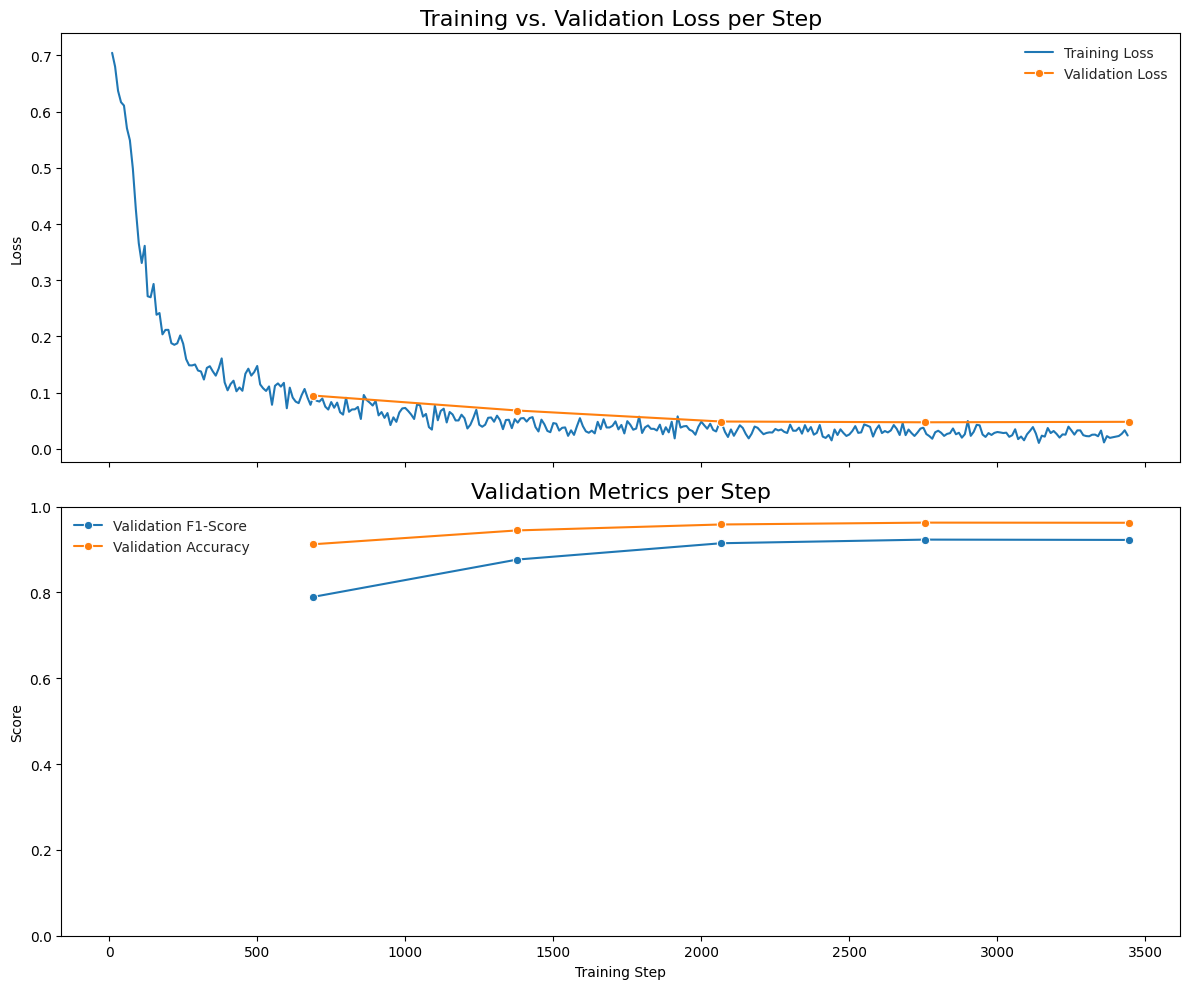


--- Best Model Evaluation Metrics (from validation set) ---
Best Epoch: 4.0
Best Step: 2756.0
Best Validation Loss: 0.0473
Best Validation F1: 0.9231
Best Validation Accuracy: 0.9627


In [1]:
# --- セル1: 環境設定 ---
import pandas as pd
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer, 
    AutoModel, 
    AutoConfig, 
    BertPreTrainedModel, 
    TrainingArguments, 
    Trainer
)
from transformers.modeling_outputs import SequenceClassifierOutput
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import GroupShuffleSplit
import accelerate
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from dataclasses import dataclass, field # 追加

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

if torch.cuda.is_available():
    print(f"✅ GPU is available. Device: {torch.cuda.get_device_name(0)}")
    device = torch.device("cuda")
else:
    print("⚠️ GPU not found. Running on CPU.")
    device = torch.device("cpu")

# --- セル2: 設定 ---
TRAINING_FILE = "data/processed/training_dataset_hard_negatives_1to3.csv"
MODEL_CHECKPOINT = "allenai/scibert_scivocab_uncased"
OUTPUT_MODEL_DIR = "models/sbert_contrastive_with_head_v1"

MAX_LENGTH = 512
BATCH_SIZE = 32
EPOCHS = 5
CONTRASTIVE_MARGIN = 1.0  
METRICS_THRESHOLD = 0.5

BERT_LEARNING_RATE = 1e-6
CLASSIFIER_LEARNING_RATE = 5e-6

print(f"Configuration set for Contrastive Loss with Classifier Head and Differential LR")

# --- セル3: カスタムモデルクラスの定義 ---
class SiameseContrastiveWithHeadModel(BertPreTrainedModel):
    def __init__(self, config):
        super(SiameseContrastiveWithHeadModel, self).__init__(config)
        self.bert = AutoModel.from_config(config)
        
        self.classifier_head = nn.Sequential(
            nn.Linear(config.hidden_size * 4, config.hidden_size),
            nn.ReLU(),
            nn.Linear(config.hidden_size, 1)
        )
        self.init_weights()

    def _get_vector(self, input_ids, attention_mask):
        output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        return output.pooler_output

    def forward(self, input_ids=None, attention_mask=None, input_ids_b=None, 
                attention_mask_b=None, labels=None, **kwargs):
        vec_x = self._get_vector(input_ids, attention_mask)
        vec_y = self._get_vector(input_ids_b, attention_mask_b)

        diff = torch.abs(vec_x - vec_y)
        prod = vec_x * vec_y
        features = torch.cat([vec_x, vec_y, diff, prod], dim=1)
        
        distance_score = self.classifier_head(features)

        return SequenceClassifierOutput(loss=None, logits=(distance_score, labels))

print("Custom model class 'SiameseContrastiveWithHeadModel' defined.")

# --- セル4: データロード, GroupSplit, トークナイズ ---
# ▼▼▼ このセルが欠落していました ▼▼▼
print(f"Loading dataset: {TRAINING_FILE}")
df_full = pd.read_csv(TRAINING_FILE)
df_full = df_full.dropna(subset=['abstract_a', 'abstract_b', 'label'])
df_full['label'] = df_full['label'].astype(int)
print(f"Full dataset size: {len(df_full)}")

print("Performing Group Shuffle Split based on 'abstract_a'...")
groups = df_full['abstract_a']
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(gss.split(df_full, groups=groups))

train_df = df_full.iloc[train_idx]
val_df = df_full.iloc[val_idx]

print(f"Train set: {len(train_df)} pairs")
print(f"Validation set: {len(val_df)} pairs")

train_anchors = set(train_df['abstract_a'])
val_anchors = set(val_df['abstract_a'])
leakage = train_anchors.intersection(val_anchors)
print(f"Data Leakage Check (Anchor Overlap): {len(leakage)} anchors")

dataset = DatasetDict({
    'train': Dataset.from_pandas(train_df),
    'validation': Dataset.from_pandas(val_df)
})
print(f"Dataset split: {dataset}")

print("Initializing tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)

def tokenize_siamese_function(examples):
    tokenized_a = tokenizer(examples["abstract_a"], padding="max_length", truncation=True, max_length=MAX_LENGTH)
    tokenized_b = tokenizer(examples["abstract_b"], padding="max_length", truncation=True, max_length=MAX_LENGTH)
    return {
        "input_ids": tokenized_a["input_ids"],
        "attention_mask": tokenized_a["attention_mask"],
        "input_ids_b": tokenized_b["input_ids"],
        "attention_mask_b": tokenized_b["attention_mask"],
    }

print("Tokenizing dataset for Siamese model...")
# ▼▼▼ 修正点: 削除する列を明示的に指定し、'label'を残す ▼▼▼
columns_to_remove = ["abstract_a", "abstract_b", "data_paper_doi"] 
# __index_level_0__ が存在する場合も削除対象に含めるとより堅牢
if '__index_level_0__' in train_df.columns:
    columns_to_remove.append('__index_level_0__')

tokenized_datasets = dataset.map(
    tokenize_siamese_function, 
    batched=True, 
    num_proc=os.cpu_count(),
    remove_columns=columns_to_remove # 'label'を含まないリストを指定
)

tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")
print("Tokenization complete.")
# ▲▲▲ --------------------------------- ▲▲▲


# --- セル5: カスタムTrainerの定義 ---
class ContrastiveWithHeadTrainer(Trainer):
    def __init__(self, *args, margin=1.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.margin = margin
        print(f"ContrastiveWithHeadTrainer initialized with margin={self.margin}")

    def compute_loss(self, model, inputs, return_outputs=False):
        outputs = model(**inputs)
        distance_score, labels = outputs.logits
        distance_score = distance_score.squeeze(-1)

        loss_positive = F.relu(distance_score)
        loss_negative = F.relu(self.margin - distance_score)
        
        loss = (labels.float() * loss_positive) + ((1 - labels.float()) * loss_negative)
        loss = loss.mean()

        return (loss, outputs) if return_outputs else loss

    def create_optimizer(self):
        if self.optimizer is None:
            bert_params = [p for n, p in self.model.named_parameters() if "bert" in n and p.requires_grad]
            classifier_params = [p for n, p in self.model.named_parameters() if "classifier_head" in n and p.requires_grad]
            
            if len(bert_params) + len(classifier_params) != len(list(p for p in self.model.parameters() if p.requires_grad)):
                print("WARNING: Some parameters are not being optimized!")
                
            optimizer_grouped_parameters = [
                {"params": bert_params, "lr": self.args.learning_rate},
                {"params": classifier_params, "lr": self.args.classifier_learning_rate},
            ]
            self.optimizer = torch.optim.AdamW(
                optimizer_grouped_parameters,
                eps=self.args.adam_epsilon,
            )
        return self.optimizer

print("Custom 'ContrastiveWithHeadTrainer' defined.")

# --- セル6: モデルのロードと訓練設定 ---
@dataclass
class CustomTrainingArguments(TrainingArguments):
    classifier_learning_rate: float = field(default=2e-5)

print(f"Loading custom model: {MODEL_CHECKPOINT}")
config = AutoConfig.from_pretrained(MODEL_CHECKPOINT)
model = SiameseContrastiveWithHeadModel(config).to(device)

print("Loading pre-trained weights for BERT part...")
bert_base_model = AutoModel.from_pretrained(MODEL_CHECKPOINT)
model.bert.load_state_dict(bert_base_model.state_dict())
del bert_base_model

print("Custom model loaded and BERT weights initialized from pre-trained model.")

def compute_metrics(eval_pred):
    distance_scores, labels = eval_pred.predictions
    distance_scores = torch.tensor(distance_scores).squeeze(-1)
    
    preds = (distance_scores < METRICS_THRESHOLD).int()
    
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary', zero_division=0)
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

training_args = CustomTrainingArguments(
    output_dir=OUTPUT_MODEL_DIR,
    learning_rate=BERT_LEARNING_RATE,
    classifier_learning_rate=CLASSIFIER_LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    logging_strategy="steps",
    logging_steps=10,
    warmup_ratio=0.1,
)
print("Training arguments set with differential learning rates.")

# --- セル7: 訓練の開始 ---
trainer = ContrastiveWithHeadTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    compute_metrics=compute_metrics,
    margin=CONTRASTIVE_MARGIN
)

print("\n--- Starting Model Training (Contrastive Loss) ---")
trainer.train()
print("--- Model Training Complete ---")

# --- セル8: モデルの保存 ---
print("Training complete. Saving best model...")
best_model_path = os.path.join(OUTPUT_MODEL_DIR, "best_model")
trainer.save_model(best_model_path)
tokenizer.save_pretrained(best_model_path)
print(f"Model saved to {best_model_path}")

# --- セル9: 訓練結果の可視化 ---
print("\n--- Visualizing Training Results ---")
log_history = trainer.state.log_history
df_log = pd.DataFrame(log_history)

df_train = df_log[df_log['loss'].notna()].copy()
df_eval = df_log[df_log['eval_loss'].notna()].copy()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
plt.style.use('seaborn-v0_8-whitegrid')

if not df_train.empty:
    sns.lineplot(data=df_train, x='step', y='loss', label='Training Loss', ax=ax1)
if not df_eval.empty:
    sns.lineplot(data=df_eval, x='step', y='eval_loss', label='Validation Loss', ax=ax1, marker='o', markersize=6)
ax1.set_title('Training vs. Validation Loss per Step', fontsize=16)
ax1.set_ylabel('Loss')
ax1.legend()

if not df_eval.empty:
    sns.lineplot(data=df_eval, x='step', y='eval_f1', label='Validation F1-Score', ax=ax2, marker='o', markersize=6)
    sns.lineplot(data=df_eval, x='step', y='eval_accuracy', label='Validation Accuracy', ax=ax2, marker='o', markersize=6)
ax2.set_title('Validation Metrics per Step', fontsize=16)
ax2.set_ylabel('Score')
ax2.set_xlabel('Training Step')
ax2.legend()
ax2.set_ylim(0, 1)

plt.tight_layout()
plt.show()

print("\n--- Best Model Evaluation Metrics (from validation set) ---")
if not df_eval.empty:
    try:
        best_run = df_eval.loc[df_eval['eval_loss'].idxmin()]
        print(f"Best Epoch: {best_run.get('epoch', 'N/A')}")
        print(f"Best Step: {best_run.get('step', 'N/A')}")
        print(f"Best Validation Loss: {best_run.get('eval_loss', -1):.4f}")
        print(f"Best Validation F1: {best_run.get('eval_f1', -1):.4f}")
        print(f"Best Validation Accuracy: {best_run.get('eval_accuracy', -1):.4f}")
    except Exception as e:
        print(f"Could not determine best run: {e}")
else:
    print("No evaluation steps were completed.")